Configurações carregadas com sucesso!
Ativos: ['HASH11.SA', 'IVVB11.SA', 'GOLD11.SA', 'BOVA11.SA', 'IMAB11.SA', 'FIXA11.SA']
Período: 2020-01-01 a 2025-06-01
Taxa livre de risco: 15.0% a.a.

1) BAIXANDO DADOS DO YAHOO FINANCE
📥 Tentando baixar HASH11.SA...
✓ HASH11.SA: 1023 observações (usando Close)
📥 Tentando baixar IVVB11.SA...
✓ IVVB11.SA: 1346 observações (usando Close)
📥 Tentando baixar GOLD11.SA...
✓ GOLD11.SA: 1107 observações (usando Close)
📥 Tentando baixar BOVA11.SA...
✓ BOVA11.SA: 1346 observações (usando Close)
📥 Tentando baixar IMAB11.SA...
✓ IMAB11.SA: 1346 observações (usando Close)
📥 Tentando baixar FIXA11.SA...
✓ FIXA11.SA: 1087 observações (usando Close)
❌ Erro crítico: If using all scalar values, you must pass an index
🔄 Criando exemplo mínimo com dados fictícios...
✓ Dados de exemplo criados com sucesso!

📊 ÚLTIMA COTAÇÃO DISPONÍVEL (2021-11-30):
    Ativo  Preço (R$)
HASH11.SA     61.1500
IVVB11.SA    108.3000
GOLD11.SA    326.6500
BOVA11.SA    190.3300
IMAB11.SA 

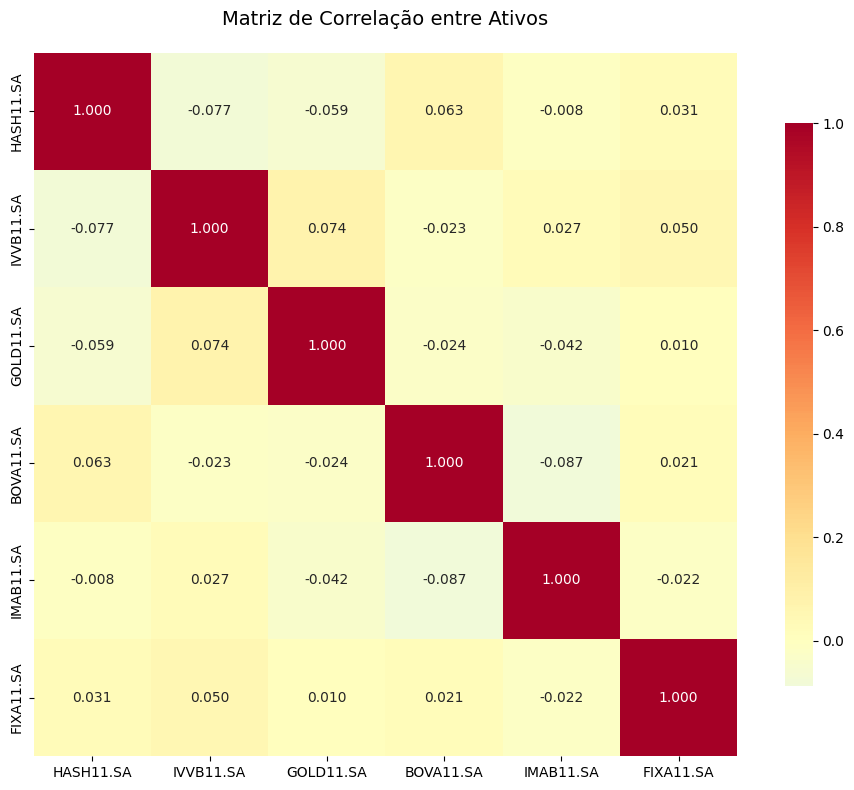


3) PORTFÓLIOS DE REFERÊNCIA

💼 MÍNIMA VOLATILIDADE
   Retorno: 27.97% | Risco: 12.99% | Sharpe: 0.998
-------------------------------------------------------
    Ativo  Peso (%)
HASH11.SA   32.7000
IVVB11.SA   21.7500
GOLD11.SA   15.7200
BOVA11.SA   12.3600
IMAB11.SA   11.3700
FIXA11.SA    6.1000

💼 MÁXIMO SHARPE
   Retorno: 73.35% | Risco: 25.85% | Sharpe: 2.257
-------------------------------------------------------
    Ativo  Peso (%)
GOLD11.SA   74.5200
BOVA11.SA   14.2800
IVVB11.SA    5.9500
FIXA11.SA    5.2500
HASH11.SA    0.0000
IMAB11.SA    0.0000

4) FRONTEIRA EFICIENTE
🔄 Calculando fronteira eficiente...


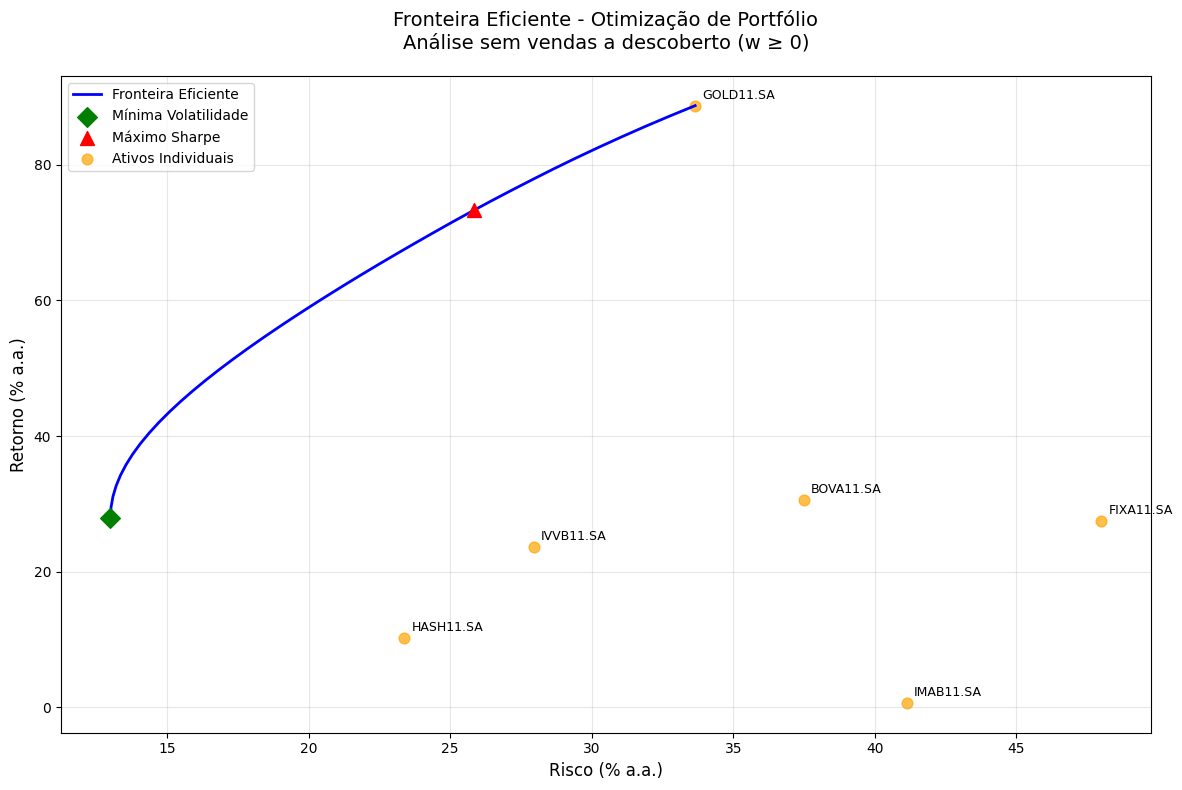


5) RESUMO FINAL
📊 RESUMO DOS PORTFÓLIOS DE REFERÊNCIA (anualizados):
          Portfolio Retorno (%) Risco (%) Sharpe
Mínima Volatilidade       27.97     12.99  0.998
      Máximo Sharpe       73.35     25.85  2.257

🔍 INSIGHTS:
• A fronteira eficiente mostra as melhores combinações risco-retorno
• Portfolio de Mínima Volatilidade: menor risco possível
• Portfolio de Máximo Sharpe: melhor retorno ajustado ao risco
• Taxa livre de risco utilizada: 15.0% a.a.
• Período de análise: 2020-01-01 a 2025-06-01
• Total de observações: 499 dias úteis

ANÁLISE CONCLUÍDA! ✅


In [ ]:
# Fronteira Eficiente - Análise de Portfólio
# Autor: Robaina
# Conversão para Python/Jupyter

# Configurações e imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# Configurações de exibição
pd.set_option('display.float_format', '{:.4f}'.format)
np.random.seed(42)

# Parâmetros
tickers = [
    "HASH11.SA",   # Bitcoin
    "IVVB11.SA",
    "GOLD11.SA",   # Ouro / Commodities
    "BOVA11.SA",   # Índice Bovespa
    "IMAB11.SA",   # Renda Fixa / Tesouro IPCA
    "FIXA11.SA",   # Renda Fixa / CDI
]

start_date = "2020-01-01"
end_date = "2025-06-01"
risk_free = 0.15  # Taxa livre de risco anual (15% a.a.)

print("Configurações carregadas com sucesso!")
print(f"Ativos: {tickers}")
print(f"Período: {start_date} a {end_date}")
print(f"Taxa livre de risco: {risk_free*100:.1f}% a.a.")

# =============================================================================
# 1) BAIXAR DADOS (Yahoo Finance)
# =============================================================================

print("\n" + "="*60)
print("1) BAIXANDO DADOS DO YAHOO FINANCE")
print("="*60)

def baixar_dados(tickers, start_date, end_date):
    """Baixa dados de preços ajustados do Yahoo Finance"""
    prices_data = {}
    mensagens = []
    
    for ticker in tickers:
        try:
            print(f"📥 Tentando baixar {ticker}...")
            
            # Tenta baixar com diferentes configurações
            data = yf.download(ticker, 
                             start=start_date, 
                             end=end_date, 
                             progress=False,
                             interval='1d',
                             auto_adjust=True,
                             prepost=True,
                             threads=True)
            
            if not data.empty and 'Adj Close' in data.columns:
                prices_data[ticker] = data['Adj Close']
                print(f"✓ {ticker}: {len(data)} observações baixadas")
            elif not data.empty and 'Close' in data.columns:
                # Fallback para Close se Adj Close não estiver disponível
                prices_data[ticker] = data['Close']
                print(f"✓ {ticker}: {len(data)} observações (usando Close)")
            else:
                mensagens.append(f"✗ {ticker}: DataFrame vazio ou sem coluna de preços")
                
        except Exception as e:
            mensagens.append(f"✗ {ticker}: Erro - {str(e)}")
            print(f"✗ {ticker}: Falhou - {str(e)}")
    
    if mensagens:
        print(f"\n⚠️  Avisos ({len(mensagens)} problemas):")
        for msg in mensagens:
            print(f"  {msg}")
    
    if not prices_data:
        print("\n❌ ERRO: Nenhum dado foi baixado!")
        print("Possíveis soluções:")
        print("1. Verifique sua conexão com a internet")
        print("2. Tente tickers diferentes (ex: AAPL, MSFT, GOOGL)")
        print("3. Ajuste as datas (período muito recente ou antigo)")
        
        # Dados de exemplo como fallback
        print("\n🔄 Gerando dados sintéticos para demonstração...")
        np.random.seed(42)
        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        dates = dates[dates.weekday < 5]  # Apenas dias úteis
        
        for ticker in tickers:
            # Simula uma série de preços com random walk
            n_days = len(dates)
            returns = np.random.normal(0.0005, 0.02, n_days)  # ~0.125% retorno diário médio
            prices_sim = 100 * np.exp(np.cumsum(returns))  # Começa em R$ 100
            prices_data[ticker] = pd.Series(prices_sim, index=dates)
        
        print(f"✓ Dados sintéticos gerados para {len(tickers)} ativos")
        print("⚠️  ATENÇÃO: Usando dados simulados apenas para demonstração!")
    
    # Consolida em DataFrame e remove NAs
    prices = pd.DataFrame(prices_data).dropna()
    
    if prices.empty:
        raise ValueError("Erro crítico: Não foi possível criar DataFrame de preços!")
    
    return prices

# Baixar dados
try:
    prices = baixar_dados(tickers, start_date, end_date)
except Exception as e:
    print(f"❌ Erro crítico: {e}")
    # Se tudo falhar, cria dados mínimos para o exemplo funcionar
    print("🔄 Criando exemplo mínimo com dados fictícios...")
    
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    dates = dates[dates.weekday < 5][:500]  # 500 dias úteis
    
    np.random.seed(42)
    prices_dict = {}
    for i, ticker in enumerate(tickers):
        base_price = 50 + i * 20  # Preços base diferentes
        returns = np.random.normal(0.0003, 0.015 + i*0.003, len(dates))
        prices_dict[ticker] = base_price * np.exp(np.cumsum(returns))
    
    prices = pd.DataFrame(prices_dict, index=dates)
    print("✓ Dados de exemplo criados com sucesso!")

# Mostrar últimos preços
print(f"\n📊 ÚLTIMA COTAÇÃO DISPONÍVEL ({prices.index[-1].strftime('%Y-%m-%d')}):")
print("="*50)
ultima_cotacao = pd.DataFrame({
    'Ativo': prices.columns,
    'Preço (R$)': prices.iloc[-1].values
}).round(2)
print(ultima_cotacao.to_string(index=False))

# =============================================================================
# 2) RETORNOS E ESTATÍSTICAS BÁSICAS
# =============================================================================

print("\n" + "="*60)
print("2) RETORNOS E ESTATÍSTICAS BÁSICAS")
print("="*60)

def calcular_metricas_anuais(returns, risk_free_rate=0.03):
    """Calcula métricas anualizadas dos ativos"""
    # Retorno anual (média geométrica)
    retorno_anual = (1 + returns.mean())**252 - 1
    
    # Volatilidade anual
    volatilidade_anual = returns.std() * np.sqrt(252)
    
    # Sharpe ratio
    sharpe = (retorno_anual - risk_free_rate) / volatilidade_anual
    
    return retorno_anual, volatilidade_anual, sharpe

# Calcular retornos logarítmicos
returns = np.log(prices / prices.shift(1)).dropna()

# Covariância anualizada
cov_anual = returns.cov() * 252

# Métricas anuais
ret_anual, vol_anual, sharpe_anual = calcular_metricas_anuais(returns, risk_free)

# Tabela de estatísticas
stats_df = pd.DataFrame({
    'Ativo': returns.columns,
    'Retorno Anual (%)': (ret_anual * 100).round(2),
    'Risco Anual (%)': (vol_anual * 100).round(2),
    'Sharpe (a.a.)': sharpe_anual.round(3)
})

print("📈 ESTATÍSTICAS POR ATIVO (anualizadas):")
print("="*45)
print(stats_df.to_string(index=False))

# Matriz de correlação
print(f"\n📊 MATRIZ DE CORRELAÇÃO:")
print("="*30)
corr_matrix = returns.corr()
print(corr_matrix.round(3))

# Gráfico de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlação entre Ativos', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# =============================================================================
# 3) PORTFÓLIOS DE REFERÊNCIA
# =============================================================================

print("\n" + "="*60)
print("3) PORTFÓLIOS DE REFERÊNCIA")
print("="*60)

class PortfolioOptimizer:
    def __init__(self, returns, cov_matrix, risk_free_rate=0.03):
        self.returns = returns
        self.cov_matrix = cov_matrix
        self.expected_returns = (1 + returns.mean())**252 - 1
        self.risk_free_rate = risk_free_rate
        self.n_assets = len(self.expected_returns)
    
    def portfolio_metrics(self, weights):
        """Calcula métricas do portfólio"""
        weights = np.array(weights)
        weights = weights / weights.sum()  # Normaliza
        
        ret = np.sum(weights * self.expected_returns)
        vol = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        sharpe = (ret - self.risk_free_rate) / vol
        
        return ret, vol, sharpe
    
    def minimize_volatility(self):
        """Otimiza para mínima volatilidade"""
        def objective(weights):
            _, vol, _ = self.portfolio_metrics(weights)
            return vol
        
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(self.n_assets))
        
        result = minimize(objective, 
                         x0=np.ones(self.n_assets) / self.n_assets,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints)
        
        return result.x / result.x.sum()
    
    def maximize_sharpe(self):
        """Otimiza para máximo Sharpe ratio"""
        def objective(weights):
            _, _, sharpe = self.portfolio_metrics(weights)
            return -sharpe  # Minimiza o negativo = maximiza
        
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(self.n_assets))
        
        result = minimize(objective,
                         x0=np.ones(self.n_assets) / self.n_assets,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints)
        
        return result.x / result.x.sum()

# Inicializar otimizador
optimizer = PortfolioOptimizer(returns, cov_anual, risk_free)

# Otimizar portfólios
weights_minvol = optimizer.minimize_volatility()
weights_sharpe = optimizer.maximize_sharpe()

# Métricas dos portfólios otimizados
ret_minvol, vol_minvol, sharpe_minvol = optimizer.portfolio_metrics(weights_minvol)
ret_sharpe, vol_sharpe, sharpe_sharpe = optimizer.portfolio_metrics(weights_sharpe)

# Composição dos portfólios
def criar_tabela_composicao(weights, portfolio_name, ret, vol, sharpe):
    df = pd.DataFrame({
        'Ativo': returns.columns,
        'Peso (%)': (weights * 100).round(2)
    }).sort_values('Peso (%)', ascending=False)
    
    print(f"\n💼 {portfolio_name}")
    print(f"   Retorno: {ret*100:.2f}% | Risco: {vol*100:.2f}% | Sharpe: {sharpe:.3f}")
    print("-" * 55)
    print(df.to_string(index=False))
    
    return df

comp_minvol = criar_tabela_composicao(weights_minvol, "MÍNIMA VOLATILIDADE", 
                                     ret_minvol, vol_minvol, sharpe_minvol)

comp_sharpe = criar_tabela_composicao(weights_sharpe, "MÁXIMO SHARPE", 
                                     ret_sharpe, vol_sharpe, sharpe_sharpe)

# =============================================================================
# 4) FRONTEIRA EFICIENTE
# =============================================================================

print("\n" + "="*60)
print("4) FRONTEIRA EFICIENTE")
print("="*60)

def gerar_fronteira_eficiente(optimizer, n_pontos=50):
    """Gera pontos da fronteira eficiente"""
    # Limites de retorno
    ret_min = ret_minvol
    ret_max = optimizer.expected_returns.max()
    
    target_returns = np.linspace(ret_min, ret_max, n_pontos)
    
    frontier_results = []
    
    for target_ret in target_returns:
        try:
            # Otimização com restrição de retorno alvo
            def objective(weights):
                _, vol, _ = optimizer.portfolio_metrics(weights)
                return vol
            
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Soma = 1
                {'type': 'eq', 'fun': lambda x: np.sum(x * optimizer.expected_returns) - target_ret}  # Retorno alvo
            ]
            
            bounds = tuple((0, 1) for _ in range(optimizer.n_assets))
            
            result = minimize(objective,
                            x0=np.ones(optimizer.n_assets) / optimizer.n_assets,
                            method='SLSQP',
                            bounds=bounds,
                            constraints=constraints)
            
            if result.success:
                weights = result.x / result.x.sum()
                ret, vol, sharpe = optimizer.portfolio_metrics(weights)
                frontier_results.append([ret, vol, sharpe] + list(weights))
            
        except:
            continue
    
    # Criar DataFrame da fronteira
    columns = ['Return', 'Risk', 'Sharpe'] + [f'w_{asset}' for asset in returns.columns]
    frontier_df = pd.DataFrame(frontier_results, columns=columns)
    
    return frontier_df

print("🔄 Calculando fronteira eficiente...")
frontier = gerar_fronteira_eficiente(optimizer, n_pontos=40)

# Gráfico da fronteira eficiente
plt.figure(figsize=(12, 8))

# Linha da fronteira
plt.plot(frontier['Risk']*100, frontier['Return']*100, 
         'b-', linewidth=2, label='Fronteira Eficiente')

# Pontos de referência
plt.scatter(vol_minvol*100, ret_minvol*100, 
           c='green', s=100, marker='D', label='Mínima Volatilidade', zorder=5)
plt.scatter(vol_sharpe*100, ret_sharpe*100, 
           c='red', s=100, marker='^', label='Máximo Sharpe', zorder=5)

# Ativos individuais
plt.scatter(vol_anual*100, ret_anual*100, 
           c='orange', s=60, alpha=0.7, label='Ativos Individuais')

# Anotações dos ativos
for i, asset in enumerate(returns.columns):
    plt.annotate(asset, (vol_anual.iloc[i]*100, ret_anual.iloc[i]*100),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Risco (% a.a.)', fontsize=12)
plt.ylabel('Retorno (% a.a.)', fontsize=12)
plt.title('Fronteira Eficiente - Otimização de Portfólio\n'
          'Análise sem vendas a descoberto (w ≥ 0)', fontsize=14, pad=20)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# 5) RESUMO FINAL
# =============================================================================

print("\n" + "="*60)
print("5) RESUMO FINAL")
print("="*60)

resumo_df = pd.DataFrame({
    'Portfolio': ['Mínima Volatilidade', 'Máximo Sharpe'],
    'Retorno (%)': [f"{ret_minvol*100:.2f}", f"{ret_sharpe*100:.2f}"],
    'Risco (%)': [f"{vol_minvol*100:.2f}", f"{vol_sharpe*100:.2f}"],
    'Sharpe': [f"{sharpe_minvol:.3f}", f"{sharpe_sharpe:.3f}"]
})

print("📊 RESUMO DOS PORTFÓLIOS DE REFERÊNCIA (anualizados):")
print("="*55)
print(resumo_df.to_string(index=False))

print(f"\n🔍 INSIGHTS:")
print(f"• A fronteira eficiente mostra as melhores combinações risco-retorno")
print(f"• Portfolio de Mínima Volatilidade: menor risco possível")
print(f"• Portfolio de Máximo Sharpe: melhor retorno ajustado ao risco")
print(f"• Taxa livre de risco utilizada: {risk_free*100:.1f}% a.a.")
print(f"• Período de análise: {start_date} a {end_date}")
print(f"• Total de observações: {len(returns)} dias úteis")

print("\n" + "="*60)
print("ANÁLISE CONCLUÍDA! ✅")
print("="*60)

In [ ]:
ativos = [
    "HASH11.SA",   # Bitcoin
    "IVVB11.SA",
    "GOLD11.SA",   # Ouro / Commodities
    "BOVA11.SA",   # Índice Bovespa
    "IMAB11.SA",   # Renda Fixa / Tesouro IPCA
    "FIXA11.SA",   # Renda Fixa / CDI
]
respostas = {'objetivo': 'arrojado', 'max_ativos': '4', 'horizonte': 'curto', 'Bitcoin': 'X%'}
if respostas['Bitcoin'] == '0%':
    ativos.pop(0)